<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Feature-engineering" data-toc-modified-id="Feature-engineering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature engineering</a></span></li><li><span><a href="#Models" data-toc-modified-id="Models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Models</a></span><ul class="toc-item"><li><span><a href="#Log-reg" data-toc-modified-id="Log-reg-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Log reg</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Catboost</a></span></li></ul></li><li><span><a href="#Clusterization" data-toc-modified-id="Clusterization-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Clusterization</a></span><ul class="toc-item"><li><span><a href="#PCA" data-toc-modified-id="PCA-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>PCA</a></span></li><li><span><a href="#t-SNE" data-toc-modified-id="t-SNE-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>t-SNE</a></span></li><li><span><a href="#UMAP" data-toc-modified-id="UMAP-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>UMAP</a></span></li><li><span><a href="#K-Means" data-toc-modified-id="K-Means-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>K-Means</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

sns.set_style("whitegrid", {'axes.grid' : False})

# from tqdm.notebook import tqdm
from tqdm.auto import tqdm

## Data

In [2]:
df = pd.read_csv('../data/transactions_train.csv')

In [3]:
df = df.sort_values(['client_id', 'trans_date'])

In [4]:
bins = pd.read_csv('../data/train_target.csv')

In [5]:
df = pd.merge(df, bins, on='client_id')

In [6]:
print('before downsampling:\n', df.dtypes)
df['client_id'] = pd.to_numeric(df['client_id'], downcast='unsigned')
df['trans_date'] = pd.to_numeric(df['trans_date'], downcast='unsigned')
df['small_group'] = pd.to_numeric(df['small_group'], downcast='signed')
df['amount_rur'] = pd.to_numeric(df['amount_rur'], downcast='float')

print('after downsampling:\n',df.dtypes)

before downsampling:
 client_id        int64
trans_date       int64
small_group      int64
amount_rur     float64
bins             int64
dtype: object
after downsampling:
 client_id       uint16
trans_date      uint16
small_group      int16
amount_rur     float32
bins             int64
dtype: object


In [7]:
groups = pd.read_csv('../data/small_group_description.csv')

In [8]:
df['weekday'] = df['trans_date'] % 7

## EDA

In [9]:
np.random.seed(228)

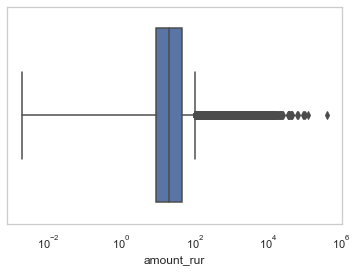

In [10]:
sns.boxplot(x=df['amount_rur'].sample(1000000))
plt.xscale('log')

In [11]:
tmp = df.groupby('small_group')[['amount_rur']].agg(['mean', 'count', 'max', 'min']).reset_index()
tmp.columns =['small_group_code', 'mean', 'count', 'max', 'min']
tmp = tmp.set_index('small_group_code')
tmp = tmp.join(groups, on='small_group_code', how='outer').reset_index(drop=True)
tmp = tmp.sort_values('count', ascending=False)
tmp

,mean,count,max,min,small_group,small_group_code
1,41.666897,8131374.0,22447.980469,0.002000,Сетевые супермаркеты и продуктовые магазины,1
11,21.339022,3202881.0,11515.068359,0.001000,Фастфуд и кафе,11
3,19.819042,2428984.0,24261.560547,0.001000,Оплата телефона и связи,3
15,21.617123,1427077.0,13318.199219,0.005000,Несетевые супермаркеты и продуктовые магазины,15
4,34.616478,1207604.0,38081.308594,0.001000,Аптеки,4
...,...,...,...,...,...,...
198,45.794998,1.0,45.794998,45.794998,Услуги починки (металлические изделия),199
199,126.484001,1.0,126.484001,126.484001,Телеграф,200
201,68.968002,1.0,68.968002,68.968002,Бетонные работы,203
202,NaN,NaN,NaN,NaN,Снегоходы,194


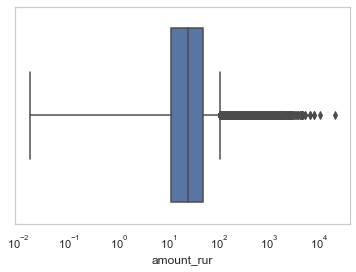

In [12]:
mask = df['small_group'] == 1
sns.boxplot(x=df[mask]['amount_rur'].sample(1000000))
plt.xscale('log')

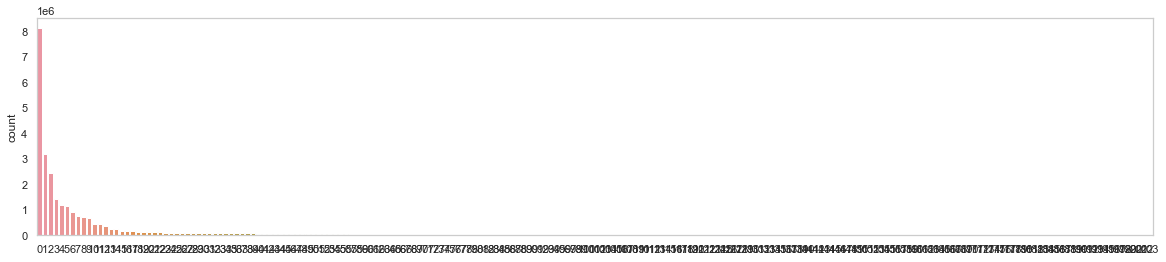

In [13]:
fig, axs = plt.subplots(figsize=(20, 4))

sns.barplot(x=list(range(len(tmp))), y=tmp['count'].sort_values(ascending=False));

In [14]:
quantiles = np.arange(0.1, 1.1, 0.1)
counts = [int(tmp['count'].quantile(i)) for i in quantiles]
quantiles = pd.DataFrame({'quantile': quantiles, 'count': counts})
quantiles

,quantile,count
0,0.1,34
1,0.2,183
2,0.3,516
3,0.4,1174
4,0.5,3287
5,0.6,11474
6,0.7,23829
7,0.8,61634
8,0.9,121845
9,1.0,8131374


In [15]:
tmp = tmp.sort_values('mean', ascending=False)
tmp

,mean,count,max,min,small_group,small_group_code
173,1352.014282,100.0,9793.549805,0.824,Металлопрокат,173
170,1344.033936,209.0,7440.359863,1.294,Окна и двери,170
181,1275.825684,73.0,16371.612305,0.190,Прочие отели (аппартаменты),181
178,1187.892944,38.0,13553.929688,3.450,Камины и печи,178
190,1180.543213,28.0,9159.056641,4.579,Услуги починки (кондиционеры и холодильники),190
...,...,...,...,...,...,...
115,17.517340,19657.0,2426.331055,0.043,"Видео (онлайн-кинотеатры, онлайн-каналы, видео...",115
47,14.888980,37602.0,1831.812012,0.043,Пекарня,47
196,12.542286,7.0,29.863001,4.313,Ортопедия,197
202,NaN,NaN,NaN,NaN,Снегоходы,194


In [16]:
tmp = tmp.sort_values('max', ascending=False)
tmp

,mean,count,max,min,small_group,small_group_code
36,77.394745,372445.0,400086.781250,0.004000,Косметика,36
80,391.396545,45405.0,319685.687500,0.043000,Аксессуары (драгоценности и часы),80
24,197.395203,462932.0,291837.218750,0.002000,Одежда,24
14,800.021484,28905.0,284318.687500,0.014000,Автодилеры и автосервис,14
21,221.938492,121548.0,219405.437500,0.009000,Больницы и поликлинники,21
...,...,...,...,...,...,...
201,68.968002,1.0,68.968002,68.968002,Бетонные работы,203
198,45.794998,1.0,45.794998,45.794998,Услуги починки (металлические изделия),199
196,12.542286,7.0,29.863001,4.313000,Ортопедия,197
202,NaN,NaN,NaN,NaN,Снегоходы,194


In [17]:
tmp = tmp.sort_values('min', ascending=False)
tmp

,mean,count,max,min,small_group,small_group_code
188,167.153000,1.0,167.153000,167.153000,Остеопаты,188
192,394.421753,4.0,800.364990,151.929993,Аренда оборудования для грузовиков и трейлеров,192
199,126.484001,1.0,126.484001,126.484001,Телеграф,200
201,68.968002,1.0,68.968002,68.968002,Бетонные работы,203
200,72.919502,2.0,93.788002,52.050999,Скорая помощь,202
...,...,...,...,...,...,...
74,39.743542,17072.0,25286.824219,0.001000,Благотворительность и краудфандинг,74
66,308.694061,10944.0,9001.336914,0.001000,Мужская одежда,66
53,143.307175,30098.0,35205.031250,0.001000,Оплата налогов,53
202,NaN,NaN,NaN,NaN,Снегоходы,194


**drop transactions from categories with low number of samples**

keep transactions from categories > 0.7 quantile

In [18]:
df = df[df['small_group'].isin(set(tmp[tmp['count'] > 23829]['small_group_code']))]

## Feature engineering

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
import gc

count of small group transactions

In [20]:
tmp = df.groupby(['client_id', 'small_group'])[['amount_rur']].count().reset_index()
tmp = tmp.pivot(index='client_id', columns='small_group', values='amount_rur')
tmp = tmp.fillna(0)

In [21]:
tmp.columns = [f'group{c}_cnt' for c in tmp.columns]

In [22]:
client_df = tmp

https://stackoverflow.com/questions/14507794/pandas-how-to-flatten-a-hierarchical-index-in-columns

count of transactions by weekday

In [23]:
tmp = df.groupby(['client_id', 'weekday'])[['amount_rur']].count().reset_index()
tmp = tmp.pivot(index='client_id', columns='weekday', values='amount_rur')
tmp = tmp.fillna(0)

In [24]:
tmp.columns = [f'weekday{c}_cnt' for c in tmp.columns]

In [25]:
client_df = client_df.join(tmp)

count of small group transactions by weekday

In [26]:
tmp = df.groupby(['client_id', 'weekday', 'small_group'])[['amount_rur']].count().reset_index()
tmp = tmp.pivot(index='client_id', columns=['small_group', 'weekday'], values='amount_rur')
tmp = tmp.fillna(0)

In [27]:
tmp.columns = [f'group{c1}_weekday{c2}_cnt' for c1, c2 in tmp.columns.values]

In [28]:
client_df = client_df.join(tmp)

mean by small group

In [29]:
tmp = df.groupby(['client_id', 'small_group'])[['amount_rur']].mean().reset_index()
tmp = tmp.pivot(index='client_id', columns='small_group', values='amount_rur')
tmp = tmp.fillna(0)

In [30]:
tmp.columns = [f'group{i}_mean' for i in tmp.columns]

In [31]:
client_df = client_df.join(tmp)

mean amount by weekday

In [32]:
tmp = df.groupby(['client_id', 'weekday'])[['amount_rur']].mean().reset_index()
tmp = tmp.pivot(index='client_id', columns='weekday', values='amount_rur')
tmp = tmp.fillna(0)

In [33]:
tmp.columns = [f'weekday{i}_mean' for i in tmp.columns]

In [34]:
client_df = client_df.join(tmp)

mean amount by small group and weekday

In [35]:
tmp = df.groupby(['client_id', 'small_group', 'weekday'])[['amount_rur']].mean().reset_index()
tmp = tmp.pivot(index='client_id', columns=['small_group', 'weekday'], values='amount_rur')
tmp = tmp.fillna(0)

In [36]:
tmp.columns = [f'group{c1}_weekday{c2}_mean' for c1, c2 in tmp.columns]

In [37]:
client_df = client_df.join(tmp)

max/min in each category

In [38]:
tmp = df.groupby(['client_id', 'small_group'])[['amount_rur']].max().reset_index()
tmp = tmp.pivot(index='client_id', columns='small_group', values='amount_rur')
tmp = tmp.fillna(0)

In [39]:
tmp.columns = [f'group{i}_max' for i in tmp.columns]

In [40]:
client_df = client_df.join(tmp)

In [41]:
tmp = df.groupby(['client_id', 'small_group'])[['amount_rur']].min().reset_index()
tmp = tmp.pivot(index='client_id', columns='small_group', values='amount_rur')
tmp = tmp.fillna(0)

In [42]:
tmp.columns = [f'group{i}_min' for i in tmp.columns]

In [43]:
client_df = client_df.join(tmp)

target

In [44]:
client_df = client_df.join(bins.set_index('client_id'))

## Models

In [45]:
from catboost import CatBoostRegressor, CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [46]:
X = client_df.drop('bins', axis=1)
y = client_df['bins']

In [47]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, shuffle=False, random_state=228)

### Log reg

In [48]:
logit = LogisticRegression(multi_class='ovr', random_state=228, solver='liblinear')
logit.fit(X_train, y_train)

/Users/th/Documents/hse_embeddings/env/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LogisticRegression(multi_class='ovr', random_state=228, solver='liblinear')

In [49]:
logit_train_pred = logit.predict_proba(X_train)
logit_valid_pred = logit.predict_proba(X_valid)

logit_train_pred = logit.predict(X_train)
logit_valid_pred = logit.predict(X_valid)

In [50]:
print(metrics.classification_report(y_valid, logit.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.48      0.34      0.40      2255
           1       0.58      0.70      0.64      2229
           2       0.64      0.80      0.71      2293
           3       0.47      0.39      0.42      2223

    accuracy                           0.56      9000
   macro avg       0.54      0.56      0.54      9000
weighted avg       0.54      0.56      0.54      9000



In [70]:
cm=metrics.confusion_matrix(y_valid, logit_valid_pred )
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# for i, r in enumerate(cm_norm):
#     r[i] = 0

<AxesSubplot:>

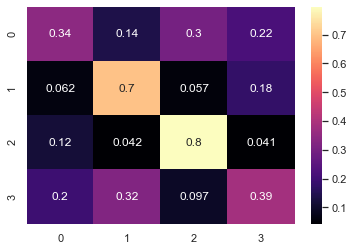

In [71]:
sns.heatmap(cm_norm, annot=True, cmap='magma')

### Catboost

In [51]:
train_pool = Pool(
    X_train, y_train,
)
val_pool = Pool(
    X_valid, y_valid,
)

In [52]:
params = {
    #'loss_function': 'Logloss',
    'loss_function':'MultiClass',
    'custom_metric': ['F1', 'Accuracy'],
    'iterations': 200,
    'random_seed': 228,
    'auto_class_weights': 'Balanced',
    #'early_stopping_rounds': 100,
    'use_best_model': True,
}

In [53]:
model = CatBoostClassifier(
    **params,
    depth=3,
    verbose=True,
    l2_leaf_reg=3,
    learning_rate=0.1
)

In [54]:
model.fit(
    train_pool,
    eval_set=val_pool,
    verbose=False, plot=True,
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [56]:
importances = [(col, imp) for (col, imp) in zip(X_train, model.get_feature_importance(train_pool))]
importances = pd.DataFrame(importances, columns=['column', 'importance'])
importances = importances.sort_values('importance', ascending=False)

<AxesSubplot:xlabel='importance', ylabel='column'>

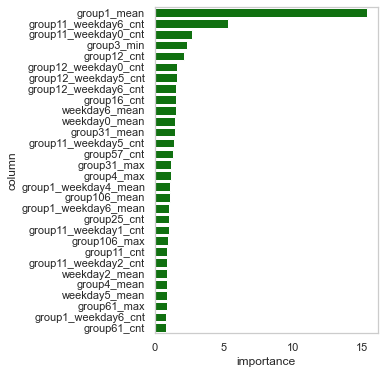

In [57]:
fig, axs = plt.subplots(figsize=(4, 6))

sns.barplot(x='importance',
            y='column',
            orient='h',
            color='green',
            data=importances.head(30))

In [59]:
y_pred = model.predict(X_valid)[:, 0]

In [60]:
print(metrics.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.49      0.50      2255
           1       0.67      0.71      0.69      2229
           2       0.73      0.80      0.76      2293
           3       0.52      0.48      0.50      2223

    accuracy                           0.62      9000
   macro avg       0.61      0.62      0.61      9000
weighted avg       0.61      0.62      0.61      9000



In [61]:
cm=metrics.confusion_matrix(y_valid, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# for i, r in enumerate(cm_norm):
#     r[i] = 0

<AxesSubplot:>

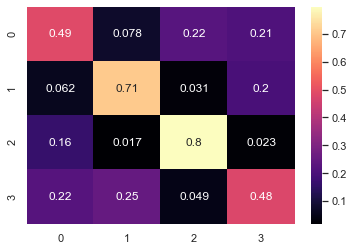

In [69]:
sns.heatmap(cm_norm, annot=True, cmap='magma')

## Clusterization

Кластеризация пользователей на основе handmade признаков обоснование выбора признаков с использованием EDA. Кластеризация пользователей любым способом, который кажется пригодным(с учетом особенностей данных). Визуализация категорий пользователей с использованием алгоритмов понижения размерности данных.

In [161]:
from sklearn.preprocessing import StandardScaler

In [76]:
# takes one minute on my pc
corr_df = client_df.corr()

In [100]:
cols = corr_df.columns
mask = (np.abs(corr_df.to_numpy()) > 0.5) & (np.abs(corr_df.to_numpy()) < 0.8)
for i, j in zip(*np.where(mask)):
    if i != j:
        pass
        #print(cols[i], cols[j], corr_df.iloc[i, j])

no any non-obvious correlation

In [103]:
X = client_df.drop('bins', axis=1)

### PCA

In [101]:
from sklearn.decomposition import PCA

In [134]:
pca = PCA(n_components=X.shape[1])
X_red = pca.fit_transform(X)

In [135]:
cum_var = np.cumsum(pca.explained_variance_ratio_)

<AxesSubplot:>

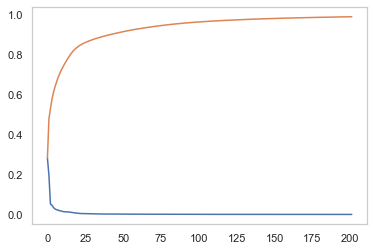

In [137]:
expl_var = pca.explained_variance_ratio_[cum_var < 0.99]
sns.lineplot(x=list(range(len(expl_var))), y=expl_var)
sns.lineplot(x=list(range(len(expl_var))), y=cum_var[cum_var < 0.99])

probably take first 25 components if need

In [177]:
X_red = X_red[:, :2]

In [178]:
df_to_plot = pd.DataFrame(X_red, columns=['PC1', 'PC2'])
df_to_plot['bins'] = client_df['bins'].astype(str)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

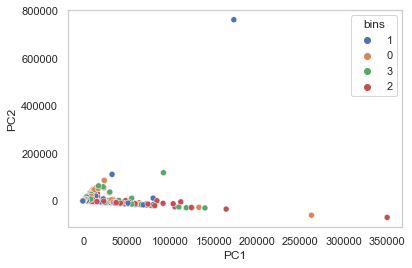

In [179]:
sns.scatterplot(x='PC1', y='PC2', hue='bins', data=df_to_plot)

remove outliers

TODO: maybe explore original dataset for outliers

In [180]:
df_to_plot = df_to_plot[(df_to_plot['PC1'] < 150000) & (df_to_plot['PC2'] < 220000)]

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

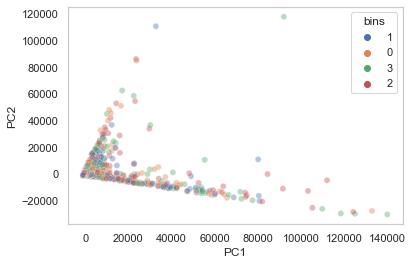

In [182]:
sns.scatterplot(
    x='PC1', y='PC2',hue='bins',
    data=df_to_plot,
    alpha=0.4)

not so evident...

### t-SNE

might have to use cuml

https://docs.rapids.ai/api/cuml/stable/api.html#cuml.TSNE

In [153]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(
    n_components=2,
    random_state=228,
    n_iter=250,
    verbose=228)
X_tsne = tsne.fit_transform(X)

### UMAP

In [167]:
from umap import UMAP

In [168]:
X_scaled = StandardScaler().fit_transform(X)

In [169]:
umap = UMAP(
    n_components=2,
    init='random',
    random_state=228)

In [171]:
# takes 20 seconds on my pc
X_umap = umap.fit_transform(X_scaled)

In [183]:
df_to_plot = pd.DataFrame(X_umap, columns=['x', 'y'])
df_to_plot['bins'] = client_df['bins'].astype(str)

<AxesSubplot:xlabel='x', ylabel='y'>

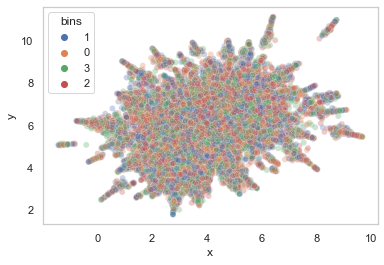

In [184]:
sns.scatterplot(
    x='x', y='y', hue='bins',
    data=df_to_plot,
    alpha=0.3)

### K-Means

In [186]:
from sklearn.cluster import KMeans

In [190]:
# 1 min 36 sec
inertia = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

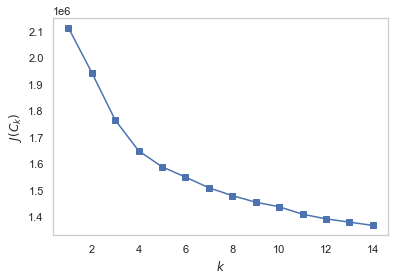

In [191]:
plt.plot(range(1, 15), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

**take weights from catboost for k-means**

**TODO: maybe cuML**
https://docs.rapids.ai/api/cuml/stable/